In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, d_model, dropout):
        super(FTTransformer, self).__init__()
        self.input_dim = input_dim

        # 入力を特徴トークンとして埋め込む
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Transformerエンコーダ層
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        
        # 出力層
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # 入力を埋め込み
        # [batch_size, input_dim] -> [batch_size, seq_len=1, d_model]
        x = self.embedding(x).unsqueeze(1)
        
        # 次元を変更 [batch_size, seq_len, d_model] -> [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)
        
        # Transformerエンコーダに通す
        x = self.transformer(x)
        
        # 最後のトークンを取得して分類
        # [seq_len, batch_size, d_model] -> [batch_size, d_model]
        x = x.mean(dim=0)  # 平均を取る
        x = self.fc(x)  # 出力層
        return torch.sigmoid(x)


学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
# 目的関数の定義
def objective(trial):
    # ハイパーパラメータのサンプリング
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.5,step=0.05)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    model = FTTransformer(input_dim=X_train.shape[1], 
                           num_heads=num_heads, 
                           num_layers=num_layers, 
                           d_model=d_model, 
                           dropout=dropout)
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs=100
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs,y_batch )
            loss.backward()
            optimizer.step()
    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return precision

In [6]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 19:02:52,151] A new study created in memory with name: no-name-02e7e6ce-7d94-4b2d-bfa7-02c2369963cb
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:03:57,906] Trial 0 finished with value: 0.5337620578778135 and parameters: {'num_heads': 8, 'num_layers': 1, 'd_model': 64, 'dropout': 0.15000000000000002, 'learning_rate': 0.016282354143651326}. Best is trial 0 with value: 0.5337620578778135.


Accuracy: 58.69%
Precision: 0.4486
Recall: 0.6587
F1 Score: 0.5338
Matthews Correlation Coefficient: 0.1973
Specificity: 0.5467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:05:52,074] Trial 1 finished with value: 0.6021505376344086 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0007603256195457132}. Best is trial 1 with value: 0.6021505376344086.


Accuracy: 57.83%
Precision: 0.4553
Recall: 0.8889
F1 Score: 0.6022
Matthews Correlation Coefficient: 0.3073
Specificity: 0.4044


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:08:40,318] Trial 2 finished with value: 0.5283018867924528 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 64, 'dropout': 0.25, 'learning_rate': 0.0878177881338969}. Best is trial 1 with value: 0.6021505376344086.


Accuracy: 35.90%
Precision: 0.3590
Recall: 1.0000
F1 Score: 0.5283
Matthews Correlation Coefficient: 0.0000
Specificity: 0.0000


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:11:01,645] Trial 3 finished wit

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:13:22,822] Trial 4 finished with value: 0.4322033898305085 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 128, 'dropout': 0.45000000000000007, 'learning_rate': 4.244410828373392e-05}. Best is trial 1 with value: 0.6021505376344086.


Accuracy: 61.82%
Precision: 0.4636
Recall: 0.4048
F1 Score: 0.4322
Matthews Correlation Coefficient: 0.1474
Specificity: 0.7378


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:14:53,241] Trial 5 finished with value: 0.45714285714285713 and parameters: {'num_heads': 2, 'num_layers': 2, 'd_model': 64, 'dropout': 0.30000000000000004, 'learning_rate': 6.794608913770452e-05}. Best is trial 1 with value: 0.6021505376344086.


Accuracy: 62.11%
Precision: 0.4706
Recall: 0.4444
F1 Score: 0.4571
Matthews Correlation Coefficient: 0.1666
Specificity: 0.7200


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:16:46,604] Trial 6 finished with value: 0.6073298429319371 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0023505018423643415}. Best is trial 6 with value: 0.6073298429319371.


Accuracy: 57.26%
Precision: 0.4531
Recall: 0.9206
F1 Score: 0.6073
Matthews Correlation Coefficient: 0.3222
Specificity: 0.3778


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:17:44,169] Trial 7 finished with value: 0.5196850393700787 and parameters: {'num_heads': 8, 'num_layers': 1, 'd_model': 128, 'dropout': 0.1, 'learning_rate': 0.000184437963402636}. Best is trial 6 with value: 0.6073298429319371.


Accuracy: 65.24%
Precision: 0.5156
Recall: 0.5238
F1 Score: 0.5197
Matthews Correlation Coefficient: 0.2474
Specificity: 0.7244


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:20:05,877] Trial 8 finished wit

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:21:36,322] Trial 9 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 2, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.05490523904454784}. Best is trial 6 with value: 0.6073298429319371.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWa

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:23:31,808] Trial 10 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.004063151390332446}. Best is trial 6 with value: 0.6073298429319371.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:25:29,239] Trial 11 finished with value: 0.5977653631284916 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.00043487155742115695}. Best is trial 6 with value: 0.6073298429319371.


Accuracy: 58.97%
Precision: 0.4612
Recall: 0.8492
F1 Score: 0.5978
Matthews Correlation Coefficient: 0.2976
Specificity: 0.4444


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:26:58,766] Trial 12 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:28:55,356] Trial 13 finished with value: 0.5 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 1.133811053666828e-05}. Best is trial 6 with value: 0.6073298429319371.


Accuracy: 60.11%
Precision: 0.4545
Recall: 0.5556
F1 Score: 0.5000
Matthews Correlation Coefficient: 0.1762
Specificity: 0.6267


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:31:41,923] Trial 14 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:33:12,647] Trial 15 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 2, 'd_model': 32, 'dropout': 0.2, 'learning_rate': 0.005206856938799152}. Best is trial 6 with value: 0.6073298429319371.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:35:34,856] Trial 16 finished with value: 0.6237113402061856 and parameters: {'num_heads': 2, 'num_layers': 4, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0003702420627410823}. Best is trial 16 with value: 0.6237113402061856.


Accuracy: 58.40%
Precision: 0.4618
Recall: 0.9603
F1 Score: 0.6237
Matthews Correlation Coefficient: 0.3679
Specificity: 0.3733


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:37:56,172] Trial 17 finished with value: 0.5477707006369427 and parameters: {'num_heads': 2, 'num_layers': 4, 'd_model': 32, 'dropout': 0.30000000000000004, 'learning_rate': 0.0001510016587105567}. Best is trial 16 with value: 0.6237113402061856.


Accuracy: 59.54%
Precision: 0.4574
Recall: 0.6825
F1 Score: 0.5478
Matthews Correlation Coefficient: 0.2205
Specificity: 0.5467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:40:42,841] Trial 18 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:43:04,155] Trial 19 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 128, 'dropout': 0.35, 'learning_rate': 0.01361821315347561}. Best is trial 16 with value: 0.6237113402061856.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enabl

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:45:27,513] Trial 20 finished with value: 0.6212121212121212 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.0004103773129754718}. Best is trial 16 with value: 0.6237113402061856.


Accuracy: 57.26%
Precision: 0.4556
Recall: 0.9762
F1 Score: 0.6212
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:47:49,129] Trial 21 finished with value: 0.6259541984732825 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.0003814910190920585}. Best is trial 21 with value: 0.6259541984732825.


Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:50:11,082] Trial 22 finished with value: 0.628140703517588 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.000385109830438782}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.83%
Precision: 0.4596
Recall: 0.9921
F1 Score: 0.6281
Matthews Correlation Coefficient: 0.3891
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:52:58,091] Trial 23 finished with value: 0.628140703517588 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00020391015744903812}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.83%
Precision: 0.4596
Recall: 0.9921
F1 Score: 0.6281
Matthews Correlation Coefficient: 0.3891
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:55:43,392] Trial 24 finished with value: 0.616580310880829 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 6.0421692624770786e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.83%
Precision: 0.4577
Recall: 0.9444
F1 Score: 0.6166
Matthews Correlation Coefficient: 0.3479
Specificity: 0.3733


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:58:29,577] Trial 25 finished with value: 0.6259541984732825 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00013193812743544738}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:01:13,057] Trial 26 finished with value: 0.624 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 3.6709722845750145e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 59.83%
Precision: 0.4699
Recall: 0.9286
F1 Score: 0.6240
Matthews Correlation Coefficient: 0.3612
Specificity: 0.4133


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:03:37,854] Trial 27 finished with value: 0.6005361930294906 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 1.7166539949872812e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.55%
Precision: 0.4534
Recall: 0.8889
F1 Score: 0.6005
Matthews Correlation Coefficient: 0.3035
Specificity: 0.4000


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:06:27,669] Trial 28 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:08:50,532] Trial 29 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 64, 'dropout': 0.2, 'learning_rate': 0.0007126698619779685}. Best is trial 22 with value: 0.628140703517588.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:11:41,493] Trial 30 finished with value: 0.6246851385390428 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 64, 'dropout': 0.4, 'learning_rate': 0.0002735076418144564}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.55%
Precision: 0.4576
Recall: 0.9841
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3783
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:14:28,167] Trial 31 finished with value: 0.6246851385390428 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00011113388194059287}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.55%
Precision: 0.4576
Recall: 0.9841
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3783
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:17:13,873] Trial 32 finished with value: 0.5994397759103641 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.0006989729655520919}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 59.26%
Precision: 0.4632
Recall: 0.8492
F1 Score: 0.5994
Matthews Correlation Coefficient: 0.3015
Specificity: 0.4489


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:19:57,700] Trial 33 finished with value: 0.6181818181818182 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.00010082113335718151}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 58.12%
Precision: 0.4595
Recall: 0.9444
F1 Score: 0.6182
Matthews Correlation Coefficient: 0.3515
Specificity: 0.3778


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:22:18,528] Trial 34 finished with value: 0.6253229974160207 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 3.138148807011191e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 58.69%
Precision: 0.4636
Recall: 0.9603
F1 Score: 0.6253
Matthews Correlation Coefficient: 0.3714
Specificity: 0.3778


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:24:23,816] Trial 35 finished with value: 0.24858757062146894 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.00011750021768094866}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 62.11%
Precision: 0.4314
Recall: 0.1746
F1 Score: 0.2486
Matthews Correlation Coefficient: 0.0622
Specificity: 0.8711


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:27:48,586] Trial 36 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:31:14,303] Trial 37 finished with value: 0.38461538461538464 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.25, 'learning_rate': 8.439904253991151e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 63.53%
Precision: 0.4878
Recall: 0.3175
F1 Score: 0.3846
Matthews Correlation Coefficient: 0.1483
Specificity: 0.8133


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:34:53,836] Trial 38 finished with value: 0.616580310880829 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.0002163529050807547}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.83%
Precision: 0.4577
Recall: 0.9444
F1 Score: 0.6166
Matthews Correlation Coefficient: 0.3479
Specificity: 0.3733


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:38:11,993] Trial 39 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:41:28,382] Trial 40 finished with value: 0.5223367697594502 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 64, 'dropout': 0.45000000000000007, 'learning_rate': 2.27781873532099e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 60.40%
Precision: 0.4606
Recall: 0.6032
F1 Score: 0.5223
Matthews Correlation Coefficient: 0.1995
Specificity: 0.6044


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:44:40,198] Trial 41 finished with value: 0.6272493573264781 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 4.474112480238049e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 58.69%
Precision: 0.4639
Recall: 0.9683
F1 Score: 0.6272
Matthews Correlation Coefficient: 0.3781
Specificity: 0.3733


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:47:23,277] Trial 42 finished with value: 0.5730659025787965 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 6.264513735582374e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 57.55%
Precision: 0.4484
Recall: 0.7937
F1 Score: 0.5731
Matthews Correlation Coefficient: 0.2461
Specificity: 0.4533


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:50:00,412] Trial 43 finished with value: 0.5431309904153354 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.00015860730835494684}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 59.26%
Precision: 0.4545
Recall: 0.6746
F1 Score: 0.5431
Matthews Correlation Coefficient: 0.2127
Specificity: 0.5467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:53:14,474] Trial 44 finished with value: 0.5548780487804879 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 5.111501119999971e-05}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 58.40%
Precision: 0.4505
Recall: 0.7222
F1 Score: 0.5549
Matthews Correlation Coefficient: 0.2221
Specificity: 0.5067


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:54:34,579] Trial 45 finished with value: 0.5037037037037037 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00035596273358270893}. Best is trial 22 with value: 0.628140703517588.


Accuracy: 61.82%
Precision: 0.4722
Recall: 0.5397
F1 Score: 0.5037
Matthews Correlation Coefficient: 0.1969
Specificity: 0.6622


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:58:18,429] Trial 46 finished with value: 0.629156010230179 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0002694475272998857}. Best is trial 46 with value: 0.629156010230179.


Accuracy: 58.69%
Precision: 0.4642
Recall: 0.9762
F1 Score: 0.6292
Matthews Correlation Coefficient: 0.3849
Specificity: 0.3689


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:01:37,042] Trial 47 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 21:04:16,460] Trial 48 finished with value: 0.6098901098901099 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0002729692083199856}. Best is trial 46 with value: 0.629156010230179.


Accuracy: 59.54%
Precision: 0.4664
Recall: 0.8810
F1 Score: 0.6099
Matthews Correlation Coefficient: 0.3250
Specificity: 0.4356


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:08:02,174] Trial 49 finished with value: 0.6121372031662269 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0011085643634859551}. Best is trial 46 with value: 0.629156010230179.


Accuracy: 58.12%
Precision: 0.4585
Recall: 0.9206
F1 Score: 0.6121
Matthews Correlation Coefficient: 0.3334
Specificity: 0.3911


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:11:19,828] Trial 50 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:15:09,243] Trial 51 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00016056464553078134}. Best is trial 46 with value: 0.629156010230179.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enabl

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:18:53,534] Trial 52 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.0002969431596659384}. Best is trial 46 with value: 0.629156010230179.
/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 21:22:39,669] Trial 53 finished with value: 0.6243654822335025 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 8.069518898860847e-05}. Best is trial 46 with value: 0.629156010230179.


Accuracy: 57.83%
Precision: 0.4590
Recall: 0.9762
F1 Score: 0.6244
Matthews Correlation Coefficient: 0.3745
Specificity: 0.3556


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:26:20,277] Trial 54 finished with value: 0.6294416243654822 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00014611773136497693}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.40%
Precision: 0.4627
Recall: 0.9841
F1 Score: 0.6294
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:29:38,525] Trial 55 finished with value: 0.6212121212121212 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0005176508960321835}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.26%
Precision: 0.4556
Recall: 0.9762
F1 Score: 0.6212
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:33:21,912] Trial 56 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 21:36:35,501] Trial 57 finished with value: 0.618925831202046 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.00019658704695881465}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4566
Recall: 0.9603
F1 Score: 0.6189
Matthews Correlation Coefficient: 0.3573
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:40:11,101] Trial 58 finished with value: 0.6194225721784777 and parameters: {'num_heads': 2, 'num_layers': 5, 'd_model': 64, 'dropout': 0.5, 'learning_rate': 4.2736213326823144e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.69%
Precision: 0.4627
Recall: 0.9365
F1 Score: 0.6194
Matthews Correlation Coefficient: 0.3526
Specificity: 0.3911


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:42:56,144] Trial 59 finished with value: 0.56875 and parameters: {'num_heads': 8, 'num_layers': 3, 'd_model': 128, 'dropout': 0.45000000000000007, 'learning_rate': 2.2956326753760725e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 60.68%
Precision: 0.4691
Recall: 0.7222
F1 Score: 0.5687
Matthews Correlation Coefficient: 0.2551
Specificity: 0.5422


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:44:57,333] Trial 60 finished with value: 0.5571847507331378 and parameters: {'num_heads': 4, 'num_layers': 2, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00043096953024122724}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 56.98%
Precision: 0.4419
Recall: 0.7540
F1 Score: 0.5572
Matthews Correlation Coefficient: 0.2173
Specificity: 0.4667


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:48:37,992] Trial 61 finished with value: 0.6259541984732825 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00010852494421363591}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:52:16,506] Trial 62 finished with value: 0.6243654822335025 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00013079625957865493}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.83%
Precision: 0.4590
Recall: 0.9762
F1 Score: 0.6244
Matthews Correlation Coefficient: 0.3745
Specificity: 0.3556


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:55:52,121] Trial 63 finished with value: 0.6208651399491094 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00021502802937777696}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4569
Recall: 0.9683
F1 Score: 0.6209
Matthews Correlation Coefficient: 0.3641
Specificity: 0.3556


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:59:24,742] Trial 64 finished with value: 0.6226912928759895 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 1.0742972177725787e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 59.26%
Precision: 0.4664
Recall: 0.9365
F1 Score: 0.6227
Matthews Correlation Coefficient: 0.3598
Specificity: 0.4000


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:02:37,513] Trial 65 finished with value: 0.6288659793814433 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00034898609624037447}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.97%
Precision: 0.4656
Recall: 0.9683
F1 Score: 0.6289
Matthews Correlation Coefficient: 0.3815
Specificity: 0.3778


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:05:54,029] Trial 66 finished with value: 0.6246851385390428 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00035662752088246665}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4576
Recall: 0.9841
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3783
Specificity: 0.3467


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 22:09:06,449] Trial 67 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 22:12:19,220] Trial 68 finished with value: 0.6142506142506142 and parameters: {'num_heads': 2, 'num_layers': 4, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0009714541094366088}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 55.27%
Precision: 0.4448
Recall: 0.9921
F1 Score: 0.6143
Matthews Correlation Coefficient: 0.3586
Specificity: 0.3067


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:15:31,538] Trial 69 finished with value: 0.6113989637305699 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.000296295101670698}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.26%
Precision: 0.4538
Recall: 0.9365
F1 Score: 0.6114
Matthews Correlation Coefficient: 0.3343
Specificity: 0.3689


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:18:47,627] Trial 70 finished with value: 0.3482587064676617 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 64, 'dropout': 0.25, 'learning_rate': 9.075169778015119e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 62.68%
Precision: 0.4667
Recall: 0.2778
F1 Score: 0.3483
Matthews Correlation Coefficient: 0.1170
Specificity: 0.8222


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:22:19,718] Trial 71 finished with value: 0.6294416243654822 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00017452383741586486}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.40%
Precision: 0.4627
Recall: 0.9841
F1 Score: 0.6294
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:26:01,555] Trial 72 finished with value: 0.6215538847117794 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00017717857941687212}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 56.98%
Precision: 0.4542
Recall: 0.9841
F1 Score: 0.6216
Matthews Correlation Coefficient: 0.3714
Specificity: 0.3378


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:29:47,921] Trial 73 finished with value: 0.62 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00022357989288231066}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 56.70%
Precision: 0.4526
Recall: 0.9841
F1 Score: 0.6200
Matthews Correlation Coefficient: 0.3680
Specificity: 0.3333


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:33:34,925] Trial 74 finished with value: 0.5283018867924528 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.09339575478505686}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 35.90%
Precision: 0.3590
Recall: 1.0000
F1 Score: 0.5283
Matthews Correlation Coefficient: 0.0000
Specificity: 0.0000


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:36:50,302] Trial 75 finished with value: 0.6208651399491094 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 6.8427801682008e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4569
Recall: 0.9683
F1 Score: 0.6209
Matthews Correlation Coefficient: 0.3641
Specificity: 0.3556


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 22:39:27,081] Trial 76 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 22:43:02,387] Trial 77 finished with value: 0.6265664160401002 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0003479812302209431}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4579
Recall: 0.9921
F1 Score: 0.6266
Matthews Correlation Coefficient: 0.3857
Specificity: 0.3422


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 22:46:49,594] Trial 78 finished with value: 0.425531914893617 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0006213586752194319}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 61.54%
Precision: 0.4587
Recall: 0.3968
F1 Score: 0.4255
Matthews Correlation Coefficient: 0.1395
Specificity: 0.7378


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 22:50:23,917] Trial 79 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 22:54:01,576] Trial 80 finished with value: 0.6233766233766234 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.0001406287513629186}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.69%
Precision: 0.4633
Recall: 0.9524
F1 Score: 0.6234
Matthews Correlation Coefficient: 0.3650
Specificity: 0.3822


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 22:57:37,689] Trial 81 finished wi

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 23:01:15,592] Trial 82 finished with value: 0.6259541984732825 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0004477587769132317}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:04:23,960] Trial 83 finished with value: 0.6272493573264781 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.00027475637238447175}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.69%
Precision: 0.4639
Recall: 0.9683
F1 Score: 0.6272
Matthews Correlation Coefficient: 0.3781
Specificity: 0.3733


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:08:09,575] Trial 84 finished with value: 0.6224489795918368 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0002755318037901093}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.83%
Precision: 0.4586
Recall: 0.9683
F1 Score: 0.6224
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3600


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:10:09,412] Trial 85 finished with value: 0.503448275862069 and parameters: {'num_heads': 4, 'num_layers': 2, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0001819247751119411}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.97%
Precision: 0.4451
Recall: 0.5794
F1 Score: 0.5034
Matthews Correlation Coefficient: 0.1682
Specificity: 0.5956


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:13:20,032] Trial 86 finished with value: 0.62 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0007483578092959912}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 56.70%
Precision: 0.4526
Recall: 0.9841
F1 Score: 0.6200
Matthews Correlation Coefficient: 0.3680
Specificity: 0.3333


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:16:58,962] Trial 87 finished with value: 0.6227848101265823 and parameters: {'num_heads': 2, 'num_layers': 5, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0002472811311567939}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4572
Recall: 0.9762
F1 Score: 0.6228
Matthews Correlation Coefficient: 0.3711
Specificity: 0.3511


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:20:16,378] Trial 88 finished with value: 0.5730994152046783 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 64, 'dropout': 0.4, 'learning_rate': 7.4545321191838e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.40%
Precision: 0.4537
Recall: 0.7778
F1 Score: 0.5731
Matthews Correlation Coefficient: 0.2498
Specificity: 0.4756


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:23:33,901] Trial 89 finished with value: 0.6233766233766234 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.00014975614113004433}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.69%
Precision: 0.4633
Recall: 0.9524
F1 Score: 0.6234
Matthews Correlation Coefficient: 0.3650
Specificity: 0.3822


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:27:12,320] Trial 90 finished with value: 0.6282722513089005 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 5.3134614759440934e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 59.54%
Precision: 0.4688
Recall: 0.9524
F1 Score: 0.6283
Matthews Correlation Coefficient: 0.3757
Specificity: 0.3956


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:30:54,193] Trial 91 finished with value: 0.5779036827195467 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 3.432271766166396e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 57.55%
Precision: 0.4493
Recall: 0.8095
F1 Score: 0.5779
Matthews Correlation Coefficient: 0.2549
Specificity: 0.4444


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:34:32,243] Trial 92 finished with value: 0.5950413223140496 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 4.913517142596972e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 58.12%
Precision: 0.4557
Recall: 0.8571
F1 Score: 0.5950
Matthews Correlation Coefficient: 0.2907
Specificity: 0.4267


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:38:25,157] Trial 93 finished with value: 0.6266318537859008 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.8678866185193544e-05}. Best is trial 54 with value: 0.6294416243654822.


Accuracy: 59.26%
Precision: 0.4669
Recall: 0.9524
F1 Score: 0.6266
Matthews Correlation Coefficient: 0.3721
Specificity: 0.3911


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:42:05,901] Trial 94 finished with value: 0.6321243523316062 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.4506550279902921e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 59.54%
Precision: 0.4692
Recall: 0.9683
F1 Score: 0.6321
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3867


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:45:42,762] Trial 95 finished with value: 0.6129032258064516 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 3.0481431719178153e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 58.97%
Precision: 0.4634
Recall: 0.9048
F1 Score: 0.6129
Matthews Correlation Coefficient: 0.3333
Specificity: 0.4133


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:49:19,842] Trial 96 finished with value: 0.6174142480211082 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.5841439267589005e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 58.69%
Precision: 0.4625
Recall: 0.9286
F1 Score: 0.6174
Matthews Correlation Coefficient: 0.3466
Specificity: 0.3956


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:52:32,341] Trial 97 finished with value: 0.5085910652920962 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 2.678480457299264e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 59.26%
Precision: 0.4485
Recall: 0.5873
F1 Score: 0.5086
Matthews Correlation Coefficient: 0.1757
Specificity: 0.5956


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:56:07,062] Trial 98 finished with value: 0.6304909560723514 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.4500780952912481e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 59.26%
Precision: 0.4674
Recall: 0.9683
F1 Score: 0.6305
Matthews Correlation Coefficient: 0.3850
Specificity: 0.3822


/tmp/ipykernel_187141/2037634495.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 23:59:48,022] Trial 99 finished with value: 0.6230366492146597 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.601823907661446e-05}. Best is trial 94 with value: 0.6321243523316062.


Accuracy: 58.97%
Precision: 0.4648
Recall: 0.9444
F1 Score: 0.6230
Matthews Correlation Coefficient: 0.3623
Specificity: 0.3911
Best Parameters:  {'num_heads': 8, 'num_layers': 5, 'd_model': 128, 'dropout': 0.5, 'learning_rate': 1.4506550279902921e-05}
Best Validation F1:  0.6321243523316062


In [13]:
best_params=study.best_params
model = FTTransformer(input_dim=X_train_tensor.shape[1],
                      num_heads=best_params["num_heads"],
                      num_layers=best_params["num_layers"],
                      d_model=best_params["d_model"],
                      dropout=best_params["dropout"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=200
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/200], Loss: 0.6739
Epoch [1/200], Train Loss: 0.6739, Val Loss: 0.6002
Epoch [2/200], Loss: 0.6584
Epoch [2/200], Train Loss: 0.6584, Val Loss: 0.5941
Epoch [3/200], Loss: 0.6418
Epoch [3/200], Train Loss: 0.6418, Val Loss: 0.5950
Epoch [4/200], Loss: 0.6327
Epoch [4/200], Train Loss: 0.6327, Val Loss: 0.5949
Epoch [5/200], Loss: 0.6247
Epoch [5/200], Train Loss: 0.6247, Val Loss: 0.5957
Epoch [6/200], Loss: 0.6220
Epoch [6/200], Train Loss: 0.6220, Val Loss: 0.5967
Epoch [7/200], Loss: 0.6146
Epoch [7/200], Train Loss: 0.6146, Val Loss: 0.5984
Epoch [8/200], Loss: 0.6146
Epoch [8/200], Train Loss: 0.6146, Val Loss: 0.5935
Epoch [9/200], Loss: 0.6036
Epoch [9/200], Train Loss: 0.6036, Val Loss: 0.5892
Epoch [10/200], Loss: 0.5963
Epoch [10/200], Train Loss: 0.5963, Val Loss: 0.5997
Epoch [11/200], Loss: 0.5997
Epoch [11/200], Train Loss: 0.5997, Val Loss: 0.5857
Epoch [12/200], Loss: 0.5974
Epoch [12/200], Train Loss: 0.5974, Val Loss: 0.5954
Epoch [13/200], Loss: 0.5925
Epoch

KeyboardInterrupt: 

Accuracy: 57.52%
Precision: 0.4750
Recall: 0.9528
F1 Score: 0.6340
Matthews Correlation Coefficient: 0.3384
Specificity: 0.3377


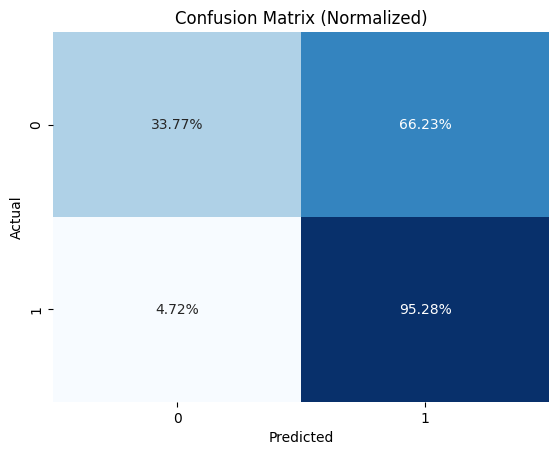

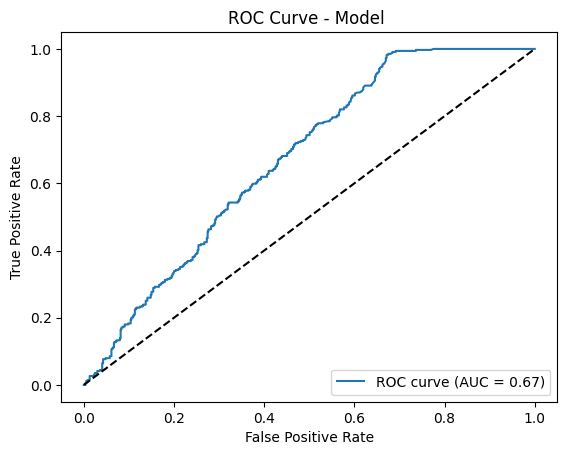

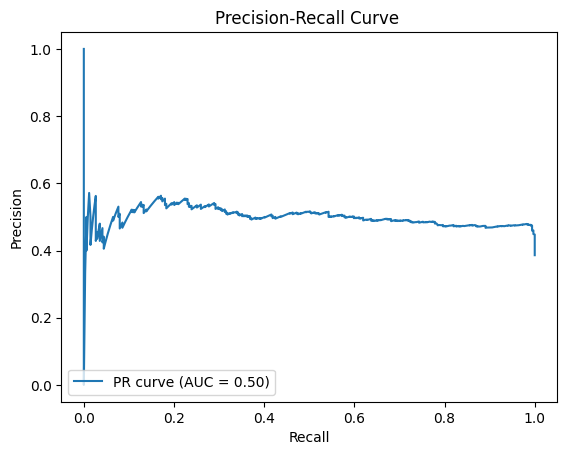

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [ ]:
# モデルと構造を保存
torch.save(model, '../../saved_model/FT_tranformer_1.pth')